# Basal Inversion: SIA Flowline (unsteady)

This notebook demonstrates how to invert for basal topography along a glacier flowline using observational data. In this example, two time-separated surfaces are used alongside measured SMB fields to model glacier dynamics without a steady-state assumption.

The inversion follows the approach of [van Pelt et al. (2013)](https://tc.copernicus.org/articles/7/987/2013/), iteratively adjusting the bed to minimize the surface misfit after forward modeling. The procedure is implemented using the [centerflow](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow.ipynb) package, which is built on top of Firedrake and icepack. 

Start by choosing a glacier:

In [1]:
name = 'Luggye' #choose your glacier from the list below, or add to it

## Glacier identification

Hard coding IDs for Bechung, Thorthormi, Rahpstreng, and Luggye. For other glaciers, it will be necessary to find their RGIIDs from v. 7.

In [2]:
glaciers = {
    'Luggye': {
        'name': 'Luggye',
        'rgiid_7': '15-09534',
    },
    'Raphstreng': {
        'name': 'Raphstreng',
        'rgiid_7': '15-09531',
    },
    'Thorthormi': {
        'name': 'Thorthormi',
        'rgiid_7': '15-09532',
    },
    'Bechung': {
        'name': 'Bechung',
        'rgiid_7': '15-09530',
    }
}

## Imports

In [3]:
from firedrake import *
import icepack
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import pandas as pd
from tqdm import trange

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow import *

## Paths

In [4]:
rgiid_7 = glaciers[name]['rgiid_7']
base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
outline6_path = base_path + 'outlines/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'

rgiid_6 = rgi6_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path, rgi6_path = outline6_path)
latlon = latlon_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path)

velocity_path = base_path + f'velocity/{rgiid_7}/MedianVelocity_2006.tif'
thickness_path = base_path + f'thickness/farinotti_ensemble/RGI60-{rgiid_6}_thickness.tif'
smb_path = base_path + 'smb/dussailant/ASE_gla_MEAN-CAL-mass-change-series_obs_unobs.csv'
# smb_path = base_path + 'smb/karma/prf_glacier_ctl.csv'

dem_path = base_path + f'elevation/farinotti/surface_DEM_RGI60-{rgiid_6}.tif'
dem_year = 2017 #the year corresponding to the DEM (probably somewhat earlier than RGI6, which was released in 2017)
start_year, end_year = 2010, 2020

dhdt_path = base_path + f'elevation/elevation_change/{start_year}_2020_dhdt/{latlon}_{start_year}-01-01_2020-01-01_dhdt.tif'

## Load data

In [5]:
n_cells = 100

mesh = centerline_mesh(rgiid = rgiid_7, centerline_path = centerline_path, outline_path = outline_path, n_cells = n_cells, extra_length = 0)
mesh = crop_mesh(mesh = mesh, data_path = dem_path) #for cases where the DEM doesn't cover the entire flowline
X = mesh.X
cell_size = mesh.length/n_cells
print('cell size = ', cell_size, 'metres')
smoothing_params = {'window': mesh.length/4, 'mesh': mesh}

thickness = map_to_mesh(mesh = mesh, data_path = thickness_path)
dem = map_to_mesh(mesh = mesh, data_path = dem_path)

try:
    velocity = map_to_mesh(mesh = mesh, data_path = velocity_path)
except:
    pass

dH_dt = map_to_mesh(mesh = mesh, data_path = dhdt_path)
dHdt_smoothed = smooth_function(function = dH_dt, **smoothing_params)
dem = smooth_function(function = dem, window = 3*cell_size, mesh = mesh)
mean_dHdt  = float(assemble(dH_dt*dx)/mesh.length)

Q = dem.function_space()
print('mean thinning rate:', mean_dHdt, 'meters per year')

cell size =  85.94884980708618 metres
Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_ensemble/RGI60-15.02373_thickness.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/farinotti/surface_DEM_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/velocity/15-09534/MedianVelocity_2006.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/elevation_change/2010_2020_dhdt/N28E090_2010-01-01_2020-01-01_dhdt.tif from EPSG:32646 to EPSG:4326
mean thinning rate: -0.4693897134118986 meters per year


## Initialize the flow model

In [6]:
T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))

opts = {
    'dirichlet_ids': [1] 
}

flow_model = icepack.models.ShallowIce()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

Δt = 1/2
num_timesteps = int((end_year - start_year)/Δt)

## Initialize reference surfaces

In [7]:
s_1 = dem.copy(deepcopy = True)
s_1.year = dem_year

s_0 = Function(Q).project(s_1 - dHdt_smoothed*(dem_year - start_year))
s_0.year = start_year

s_2 = Function(Q).project(dem + dHdt_smoothed*(end_year - dem_year))
s_2.year = end_year

u = Function(Q).project(Constant(0))

## Initialize SMB data

SMB data consist of single glacier-averaged values at each timestep. The inversion performs poorly with data this coarse. We can create slightly more realistic data by assuming that SMB varies with elevation via some lapse rate, and we construct a spatially variable SMB field whose spatial average is the appropriate value. The lapse rate is chosen so that the spread in SMB values is similar to the spread in the observed thinning rate. 

In [8]:
df = pd.read_csv(smb_path)
row = df.loc[df["RGIId"] == f'RGI60-{rgiid_6}']
x_t = mesh.length

dem_adjusted = Function(Q).project(dem - dem.at(x_t, tolerance = 1e-10)) #shift DEM so that the glacier front is at 0
lapse_rate = 0.003 #obtained by trial and error

smb_expr = lapse_rate*dem_adjusted #SMB is of the form smb = a*elevation + b, where a is the lapse rate and b is to be determined
temp_mean = assemble(smb_expr*dx)/mesh.length #the spatial mean of the expression smb = a*elevation + 0, which will need correcting

smb_dict = {} #list of glacier-wide specific SMB values (one per year)
for step in range(num_timesteps):
    decimal_year = s_0.year + step*Δt
    int_year = s_0.year + int(step*Δt)
    smb_mean = float(row[str(int_year)].iloc[0])
    b = smb_mean - temp_mean #how far off is our guess?
    entry = Function(Q).project(smb_expr + b) #adjust by this much
    smb_dict[decimal_year] = entry

Text(0, 0.5, 'elevation change rate (m per year)')

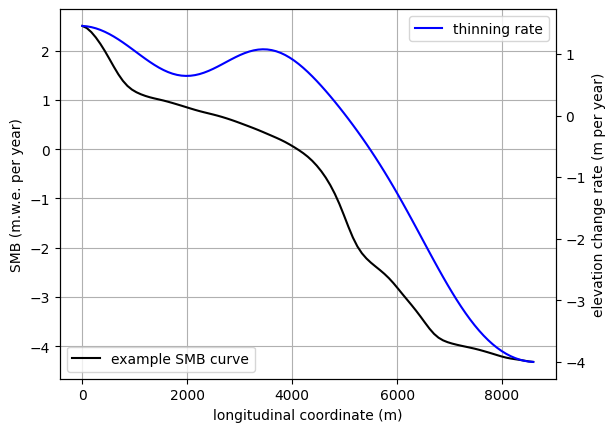

In [9]:
plt.figure()
plt.plot(X, smb_dict[2017.0].at(X, tolerance = 1e-10), color = 'k', label = 'example SMB curve')
plt.grid()
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('SMB (m.w.e. per year)')
plt.legend(loc = 'lower left')

plt.twinx()
plt.plot(X, dHdt_smoothed.at(X, tolerance = 1e-10), color = 'blue', label = 'thinning rate')
plt.legend(loc = 'upper right')
plt.ylabel('elevation change rate (m per year)')

## Invert for basal topography

In [10]:
inversion_params = {
    'model': flow_model,
    'solver': flow_solver,
    'mesh': mesh,
    'fluidity': A,
    'surface': s_0,
    'surface_2': s_1,
    'accumulation': smb_dict
}
    
inversion = solve_bed(K = 0.1, num_iterations = 50, thickness_guess = firedrake.Constant(200), velocity = u, 
                      **inversion_params)

100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


## Visualize the results

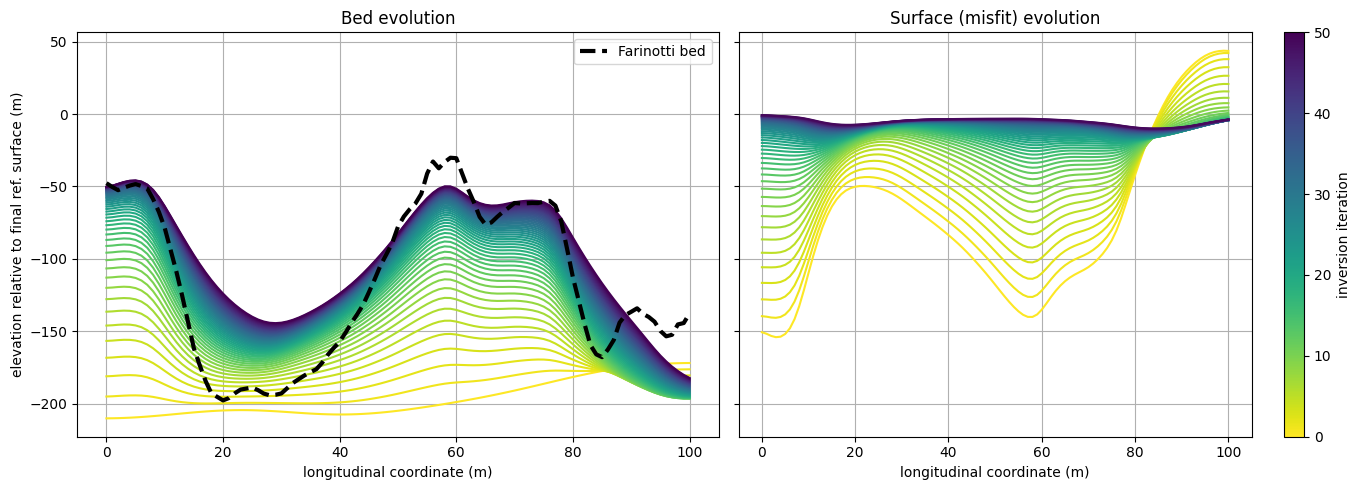

In [11]:
s_ref = inversion.s_ref
s_ref_array = np.array(s_ref.at(X, tolerance=1e-10)) 

farinotti_bed = firedrake.Function(Q).project(dem - thickness)
farinotti_bed_relative = farinotti_bed.at(X, tolerance=1e-10) - s_ref_array

# Outputs from the function
bed_evolution = inversion.bed_evolution
surface_evolution = inversion.surface_evolution

N = len(bed_evolution)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N - 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: Bed evolution
for i, entry in enumerate(bed_evolution):
    axes[0].plot(entry - s_ref_array, color=cmap(norm(i)))
axes[0].plot(farinotti_bed_relative, color='k', linestyle='dashed', linewidth=3, label='Farinotti bed')
axes[0].set_title('Bed evolution')
axes[0].set_xlabel('longitudinal coordinate (m)')
axes[0].set_ylabel('elevation relative to final ref. surface (m)')
# axes[0].set_ylim(-400, 50)
axes[0].legend()
axes[0].grid()

# Right: Surface evolution
for i, entry in enumerate(surface_evolution):
    axes[1].plot(entry - s_ref_array, color=cmap(norm(i)))
axes[1].set_title('Surface (misfit) evolution')
axes[1].set_xlabel('longitudinal coordinate (m)')
axes[1].grid()

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=axes[1], orientation='vertical', label='inversion iteration')

plt.tight_layout()
plt.show()


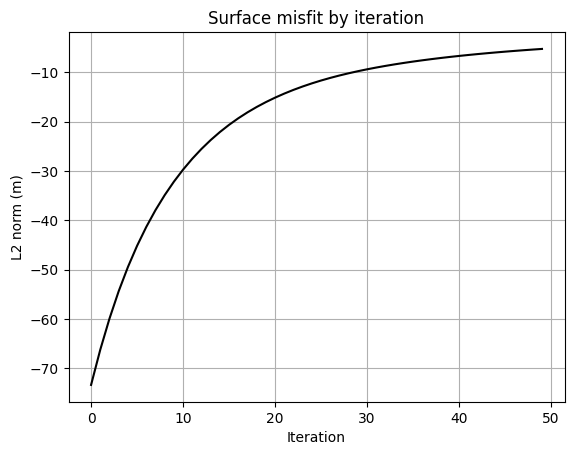

In [12]:
plt.figure()
plt.title('Surface misfit by iteration')
plt.plot(range(len(inversion.misfits)), inversion.misfits, color='k')
plt.ylabel('L2 norm (m)')
plt.xlabel('Iteration')
plt.grid(True, which='both')
# plt.ylim(0, 17500)  # Uncomment if you want the y-axis to start at 0
plt.show()

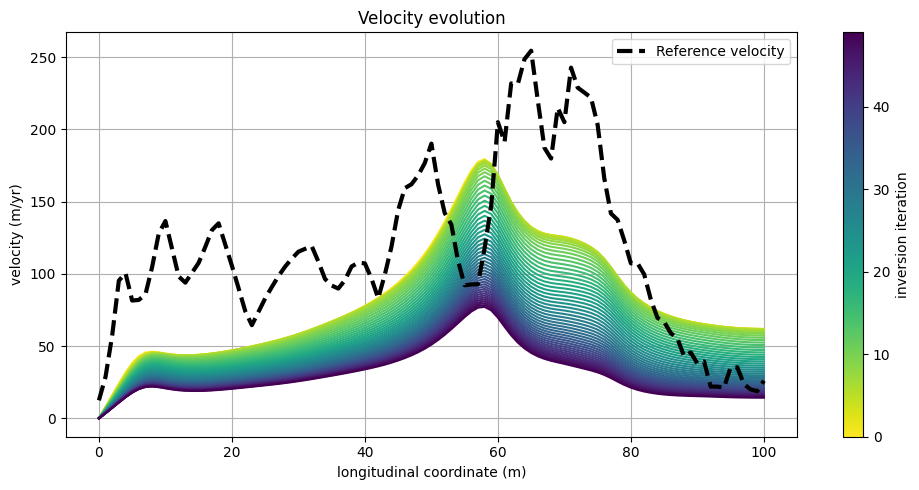

In [13]:
velocity_evolution = inversion.velocity_evolution
N = len(velocity_evolution)

cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N - 1)

fig, ax = plt.subplots(figsize=(10, 5))

for i, v_iter in enumerate(velocity_evolution):
    ax.plot(v_iter, color=cmap(norm(i)))

# Reference velocity (already precomputed on X)
try:
    velocity_ref = velocity.at(X, tolerance = 1e-10)
    ax.plot(velocity_ref, color='k', linestyle='dashed', linewidth=3, label='Reference velocity')
    ax.legend()
except:
    pass

ax.set_title('Velocity evolution')
ax.set_xlabel('longitudinal coordinate (m)')
ax.set_ylabel('velocity (m/yr)')
ax.grid()

sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, label='inversion iteration')

plt.tight_layout()
plt.show()

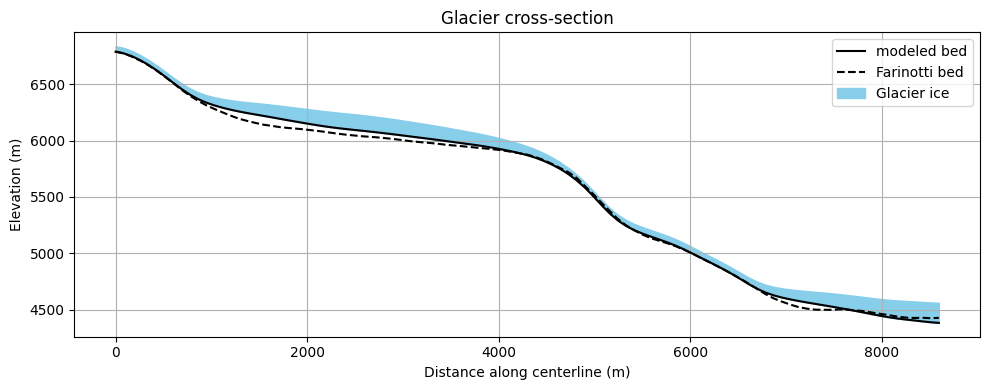

In [14]:
surface = surface_evolution[-1]
bed = bed_evolution[-1]

plt.figure(figsize = (10, 4))
plt.plot(X, bed, color = 'black', label = 'modeled bed')
plt.plot(X, farinotti_bed.at(X, tolerance = 1e-10), color = 'k', linestyle = 'dashed', label = 'Farinotti bed')
# plt.plot(X, surface, color = 'blue', label = 'surface')
plt.fill_between(X, bed, surface, color = 'skyblue', label = 'Glacier ice')

plt.xlabel('Distance along centerline (m)')
plt.ylabel('Elevation (m)')
plt.title('Glacier cross-section')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()